In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd 
import seaborn as sns 
import statistics
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from ydata_profiling import ProfileReport

In [4]:
%matplotlib inline

In [5]:
modeldf2019 = pd.read_csv('mydata/MMSA2019.csv',encoding='latin-1',index_col=[0])
modeldf2021 = pd.read_csv('mydata/MMSA2021.csv',encoding='latin-1',index_col=[0])

In [6]:
#pd.set_option('display.max_columns', None)

In [7]:
pd.set_option('display.max_info_columns', 1000)
pd.set_option('display.max_info_rows', 1000000)

In [8]:
import io
buffer = io.StringIO()
modeldf2019.info(buf=buffer)
info_str = buffer.getvalue()
print(info_str)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 210771 entries, 1 to 210771
Data columns (total 179 columns):
 #    Column    Non-Null Count   Dtype  
---   ------    --------------   -----  
 0    DISPCODE  210771 non-null  int64  
 1    STATERE1  71738 non-null   float64
 2    CELPHONE  71738 non-null   float64
 3    LADULT1   71738 non-null   float64
 4    COLGSEX   21 non-null      float64
 5    LANDSEX   30365 non-null   float64
 6    RESPSLCT  36285 non-null   float64
 7    SAFETIME  139033 non-null  float64
 8    CADULT1   139033 non-null  float64
 9    CELLSEX   139026 non-null  float64
 10   HHADULT   139028 non-null  float64
 11   SEXVAR    210771 non-null  int64  
 12   GENHLTH   210753 non-null  float64
 13   PHYSHLTH  210750 non-null  float64
 14   MENTHLTH  210761 non-null  float64
 15   POORHLTH  116171 non-null  float64
 16   HLTHPLN1  210764 non-null  float64
 17   PERSDOC2  210765 non-null  float64
 18   MEDCOST   210765 non-null  float64
 19   CHECKUP1  210763 non-

In [9]:
buffer = io.StringIO()
modeldf2021.info(buf=buffer)
info_str = buffer.getvalue()
print(info_str)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 227792 entries, 1 to 227792
Data columns (total 152 columns):
 #    Column    Non-Null Count   Dtype  
---   ------    --------------   -----  
 0    DISPCODE  227792 non-null  int64  
 1    STATERE1  55524 non-null   float64
 2    CELPHON1  55524 non-null   float64
 3    LADULT1   55524 non-null   float64
 4    COLGSEX   18 non-null      float64
 5    LANDSEX   23345 non-null   float64
 6    RESPSLCT  30824 non-null   float64
 7    SAFETIME  172268 non-null  float64
 8    CADULT1   172268 non-null  float64
 9    CELLSEX   172267 non-null  float64
 10   HHADULT   172267 non-null  float64
 11   SEXVAR    227792 non-null  int64  
 12   GENHLTH   227790 non-null  float64
 13   PHYSHLTH  227790 non-null  float64
 14   MENTHLTH  227792 non-null  int64  
 15   POORHLTH  122851 non-null  float64
 16   PRIMINSR  227791 non-null  float64
 17   PERSDOC3  227792 non-null  int64  
 18   MEDCOST1  227791 non-null  float64
 19   CHECKUP1  227792 non-

### Converting 2019 BRFSS Dataframe Columns to appropriate datatype

In [10]:
#Any variable with value counts below 14 with be turned to a categorical nominal datatype:
# Convert 'col1' from float to categorical
for col in modeldf2019.columns:
    if len(modeldf2019[col].value_counts()) < 15:
        modeldf2019[col] = modeldf2019[col].astype('category')
        
for col in modeldf2021.columns:
    if len(modeldf2021[col].value_counts()) < 15:
        modeldf2021[col] = modeldf2021[col].astype('category')
               

In [11]:
##Extract state from MMSANAME
def get_state(col):
    return col.split(',')[1]

modeldf2019['STATE'] = modeldf2019['MMSANAME'].apply(get_state)
modeldf2021['STATE'] = modeldf2021['MMSANAME'].apply(get_state)

In [12]:
columns = ['FRNCHDA_','POTADA1_', 'FRUTDA2_', 'FTJUDA2_', 'VEGEDA2_', 'GRENDA1_', 
                '_FRUTSU1', '_VEGESU1', '_HLTHPLN','PRIMINSR', '_RACE', 'MEDCOST1', 'MARITAL', '_EDUCAG', 
                'RENTHOM1', 'EMPLOY1', 'CHILDREN', '_INCOMG1', '_TOTINDA', 'CHCOCNCR', 'SMOKE100', 
                'SMOKDAY2', 'USENOW3','_SMOKER3', '_RFSMOK3','_RFBING5', 'DIABETE4','EXERANY2', 
                'CHCOCNCR', '_MICHD', '_RFHYPE6', '_RFCHOL3', 'ADDEPEV3', 'DECIDE','_AGE65YR', 
                'WTKG3', '_BMI5', '_BMI5CAT', '_SEX','STATE','SEQNO','_RFHLTH']
len(columns)

42

In [13]:
#RENAME COLUMNS in 2019 dataset to match 2021:
modeldf2019.rename(columns={'_INCOMG':'_INCOMG1','_RFHYPE5':'_RFHYPE6','HLTHPLN1': 'PRIMINSR','MEDCOST':'MEDCOST1',
                  '_RFCHOL2':'_RFCHOL3'},inplace=True)

In [14]:
#Create a _HLTHPLN from PRIMINSR IN 2019 df (- '_HLTHPLN' - Categorical variable for healthcare plan )

modeldf2019['_HLTHPLN'] = modeldf2019['PRIMINSR'].apply(lambda x: 1 if x in [1,2,3,4,5,6,7,8,9] 
                                                        else 2 if x == 88 else 'NA')

modeldf2019['_TOTINDA'] = modeldf2019['_TOTINDA'].astype(float)

#Create a DROCDY3_ from ALCDAY5 by dividing the ALCDAY5 variable by 7 days per week or 30 days per month
def compute_drocdy3_(x):
    # Handle NaN values
    if pd.isna(x):
        return np.nan
    
    x_int = int(str(x).split(".")[0])
    
    if x_int == 888:
        return 0.0
    elif x_int // 100 == 1:
        return (x_int % 100) / 7.0
    elif x_int // 100 == 2:
        return (x_int % 100) / 30.0
    elif x_int in [777, 999]:
        return np.nan
    else:
        return float(x_int)

modeldf2019['DROCDY3_'] = modeldf2019['ALCDAY5'].apply(compute_drocdy3_)
modeldf2021['DROCDY3_'] = modeldf2021['ALCDAY5'].apply(compute_drocdy3_)

In [15]:
# Get common columns
common_columns = modeldf2019.columns.intersection(modeldf2021.columns)

# 2021 index with common columns
brfss_df = modeldf2021[common_columns]

In [16]:
#Lets clean up 2021 and keep as our validation dataset

In [17]:
#Convert appropriate columns into categories
# List of columns to convert
columns_list = ['_AGE65YR', '_INCOMG1', '_TOTINDA', '_HLTHPLN', '_RFBING5', 
                'PRIMINSR', '_EDUCAG', '_SMOKER3','_RFSMOK3','_SEX', '_RFHYPE6','PHYSHLTH',
                '_RFHLTH','MENTHLTH','_AGEG5YR','_ASTHMS1','_HISPANC','ALCDAY5',
                "CHECKUP1","CVDSTRK3","CHCSCNCR","CHCOCNCR","ADDEPEV3","CHCKDNY2", "DIABETE4",'_RACE']

# Convert each column to category data type in place
for col in columns_list:
    brfss_df[col] = brfss_df[col].astype('category')

#convert height to height in meters
def calculate_htinm(height3):
    if 300 <= height3 <= 311:
        htinm = ((height3 - 300) + 36)*0.0254
    elif 400 <= height3 <= 411:
        htinm = ((height3 - 400) + 48)*0.0254
    elif 500 <= height3 <= 511:
        htinm = ((height3 - 500) + 60)*0.0254
    elif 600 <= height3 <= 611:
        htinm = ((height3 - 600) + 72)*0.0254
    elif 700 <= height3 <= 711:
        htinm = ((height3 - 700) + 84)*0.0254
    else:
        htinm = None  # Handle cases that don't match any condition
    
    return htinm

brfss_df['HEIGHT3'] = brfss_df['HEIGHT3'].apply(calculate_htinm)


In [18]:
brfss_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 227792 entries, 1 to 227792
Data columns (total 136 columns):
 #    Column    Non-Null Count   Dtype   
---   ------    --------------   -----   
 0    DISPCODE  227792 non-null  category
 1    STATERE1  55524 non-null   category
 2    LADULT1   55524 non-null   category
 3    COLGSEX   18 non-null      category
 4    LANDSEX   23345 non-null   category
 5    RESPSLCT  30824 non-null   category
 6    SAFETIME  172268 non-null  category
 7    CADULT1   172268 non-null  category
 8    CELLSEX   172267 non-null  category
 9    HHADULT   172267 non-null  float64 
 10   SEXVAR    227792 non-null  category
 11   GENHLTH   227790 non-null  category
 12   PHYSHLTH  227790 non-null  category
 13   MENTHLTH  227792 non-null  category
 14   POORHLTH  122851 non-null  float64 
 15   PRIMINSR  227791 non-null  category
 16   MEDCOST1  227791 non-null  category
 17   CHECKUP1  227792 non-null  category
 18   BPMEDS    84782 non-null   category
 19   

In [19]:
#Lets make a copy of the merged dataframe
processed_features_df = brfss_df.copy()

#Place decimal place in fruit and vegetable columns (as it was implied)
def convert_decimal(x):
    if pd.isna(x):
        return np.nan
    else:
        return x/100
    
cols = ['FRNCHDA_','POTADA1_', 'FRUTDA2_', 'FTJUDA2_', 'VEGEDA2_', 'GRENDA1_', 
                '_FRUTSU1', '_VEGESU1','WTKG3','_BMI5']

#Convert features to appropriate values by placing the decimal place 
for col in cols:
    processed_features_df[col] = processed_features_df[col].apply(convert_decimal)
    
#Convert STATE column to US state
from States import states
processed_features_df['STATE'] = processed_features_df['STATE'].apply(lambda x: states[(x[-2:])] 
                                                                      if (x[-2:]) in states else x)

### Generate EDA Report with Original Dataset

In [20]:
#profile = ProfileReport(modeldf2021)
#profile.to_file(output_file="mydata/EDA_Report_2021.html")

### Handle Missing data

In [21]:
pd.reset_option('display.max_rows',None)

In [22]:
#check missing values in train dataset
total = processed_features_df.isnull().sum().sort_values(ascending=False)
percent = (processed_features_df.isnull().sum()/processed_features_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
print(missing_data.to_string())

           Total   Percent
COLGSEX   227774  0.999921
NUMPHON3  211707  0.929387
LANDSEX   204447  0.897516
CAGEG     201128  0.882946
DIABAGE3  199821  0.877208
RESPSLCT  196968  0.864684
ASTHNOW   195581  0.858595
PREGNANT  182883  0.802851
NUMHHOL3  172269  0.756256
LADULT1   172268  0.756251
STATERE1  172268  0.756251
LMTJOIN3  158813  0.697184
ARTHEXER  158813  0.697184
ARTHEDU   158813  0.697184
JOINPAI2  158813  0.697184
ARTHDIS2  158813  0.697184
HIVTSTD3  155405  0.682223
_FLSHOT7  149524  0.656406
_PNEUMO3  149524  0.656406
SMOKDAY2  145458  0.638556
BPMEDS    143010  0.627810
FLSHTMY3  115386  0.506541
MAXDRNKS  113755  0.499381
DRNK3GE5  113425  0.497932
AVEDRNK3  113057  0.496317
POORHLTH  104941  0.460688
CELLSEX    55525  0.243753
HHADULT    55525  0.243753
SAFETIME   55524  0.243749
CADULT1    55524  0.243749
_VEGESU1   32613  0.143170
_RFCHOL3   29981  0.131616
_FRUTSU1   27859  0.122300
VEGEDA2_   26817  0.117726
POTADA1_   26756  0.117458
_BMI5CAT   26341  0.115636
_

In [23]:
#Drop columns with more that 45% missing values 
col_more45 = list(missing_data.index[missing_data['Percent'] > 0.46])
col_more45
processed_features_df.drop(columns=col_more45,inplace=True)

#Drop columns that are of very low variance and have high unque vales and may be of no importance to ones health

processed_features_df.drop(columns=['SAFETIME','CELLSEX','DISPCODE','_MMSA','_MMSAWT'],inplace=True)
processed_features_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 227792 entries, 1 to 227792
Data columns (total 105 columns):
 #    Column    Non-Null Count   Dtype   
---   ------    --------------   -----   
 0    CADULT1   172268 non-null  category
 1    HHADULT   172267 non-null  float64 
 2    SEXVAR    227792 non-null  category
 3    GENHLTH   227790 non-null  category
 4    PHYSHLTH  227790 non-null  category
 5    MENTHLTH  227792 non-null  category
 6    PRIMINSR  227791 non-null  category
 7    MEDCOST1  227791 non-null  category
 8    CHECKUP1  227792 non-null  category
 9    CVDINFR4  227792 non-null  category
 10   CVDCRHD4  227792 non-null  category
 11   CVDSTRK3  227792 non-null  category
 12   ASTHMA3   227792 non-null  category
 13   CHCSCNCR  227792 non-null  category
 14   CHCOCNCR  227792 non-null  category
 15   ADDEPEV3  227792 non-null  category
 16   CHCKDNY2  227792 non-null  category
 17   DIABETE4  227792 non-null  category
 18   MARITAL   227791 non-null  category
 19   

##### Vegetable and fruit columns calculated from other veg_fruit columns (So we will keep only these ones)
     'FRNCHDA_'- french fry intake in time per day 2
     'POTADA1_' - computed potatoe servings per day 
     'FRUTDA2_',- number of fruits consunmed per day 
     'FTJUDA2_'- computed fruit juice intake in times per day 
     'VEGEDA2_', - COMPUTED NUMBER OF OTHER VEGIES eaten per day - not lettuce or potatoe 
     'GRENDA1_'- Number of dark green vegetables per day Times per day  
     'FRUTSU1', Number of Fruits consumed per day 
     'VEGESU1', Number of Vegetables consumed per day 


In [24]:
#Drop redundant Columns and irreleveant columns
processed_features_df.drop(columns=['SEQNO','_AGE80','_AGE65YR','_AGE_G','SEXVAR',
                                    'WEIGHT2','_CASTHM1','_LTASTH1','PRIMINSR','EXERANY2','CHILDREN','EDUCA',
                                    'ASTHMA3','SMOKE100','CPDEMO1B','_STSTR','CVDINFR4','CVDCRHD4','_RACEG21'
                                   ,'_RACEGR3','_PRACE1','_MRACE1','_IMPSEX','CADULT1','GENHLTH',
                                    'HHADULT','_RFBMI5','VEGETAB2','POTATOE1','FRENCHF1',
                                    'FVGREEN1','FRUITJU2','FRUIT2','HIVTST7'],inplace=True)

<Axes: >

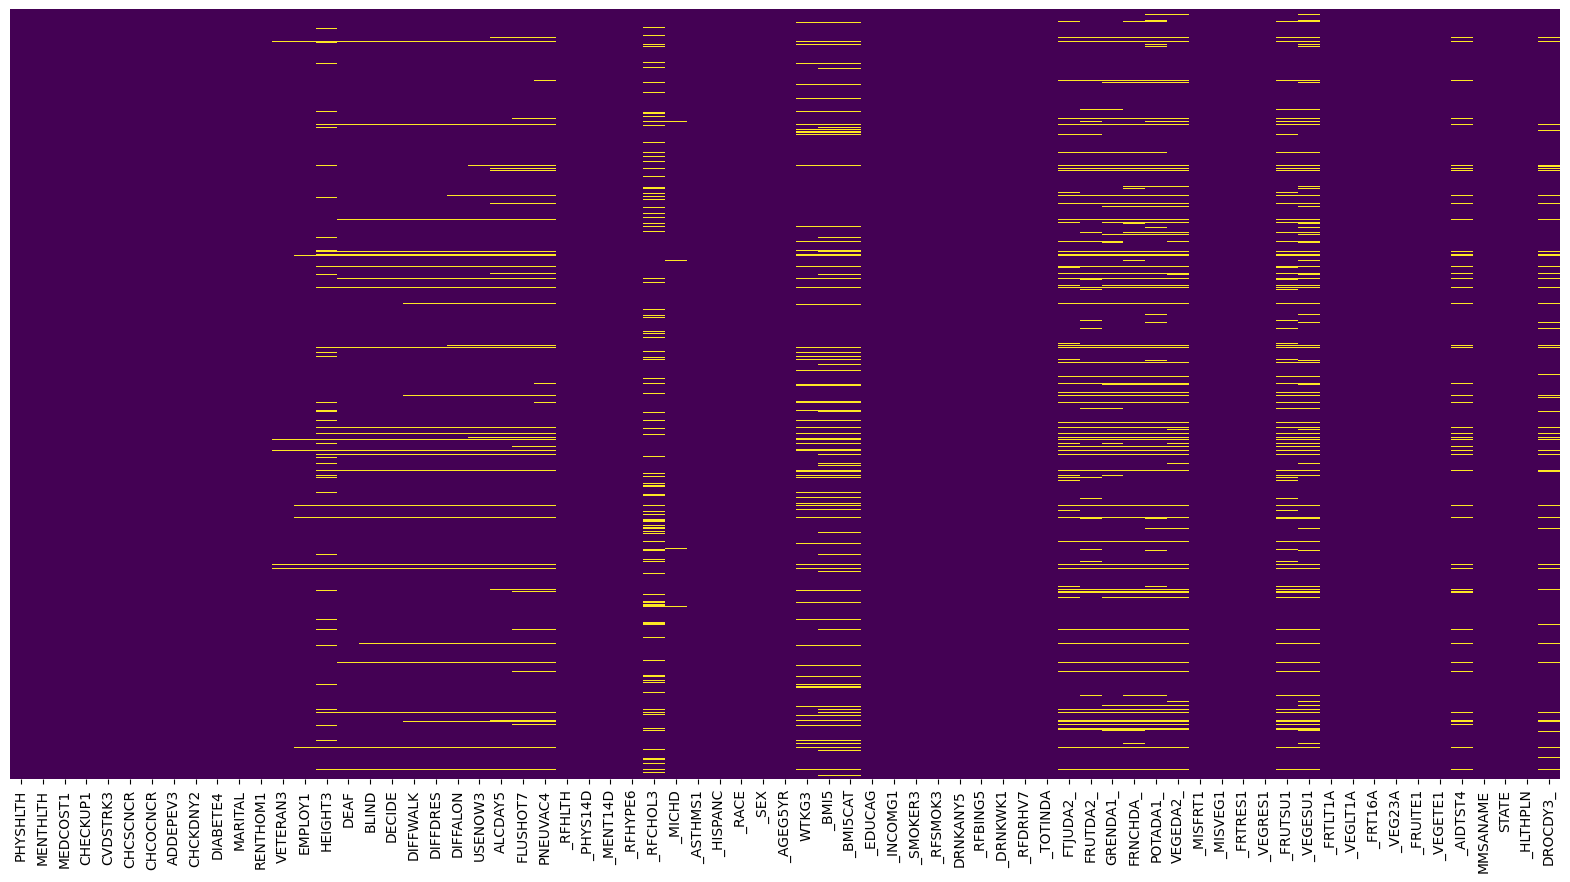

In [25]:
#vizualize misisng values using a heatmap
plt.figure(figsize=(20,10))
sns.heatmap(processed_features_df.isnull(),yticklabels=False,cmap='viridis',cbar=False)

In [26]:
#Drop the rows where columns have less than 5% missing values 
#list of columns with less than 5% missing data 

#check missing values in train dataset
total = processed_features_df.isnull().sum().sort_values(ascending=False)
percent = (processed_features_df.isnull().sum()/processed_features_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

col_less5miss = list(missing_data.index[missing_data['Percent'] < 0.05])
processed_features_df.dropna(subset=col_less5miss,inplace=True)

In [27]:
print(missing_data.to_string())

          Total   Percent
_VEGESU1  32613  0.143170
_RFCHOL3  29981  0.131616
_FRUTSU1  27859  0.122300
VEGEDA2_  26817  0.117726
POTADA1_  26756  0.117458
_BMI5CAT  26341  0.115636
_BMI5     26341  0.115636
FRNCHDA_  24886  0.109249
FTJUDA2_  24654  0.108230
GRENDA1_  24449  0.107330
FRUTDA2_  24097  0.105785
WTKG3     22711  0.099701
_AIDTST4  17092  0.075033
DROCDY3_  17031  0.074766
PNEUVAC4  16477  0.072334
HEIGHT3   15888  0.069748
FLUSHOT7  15649  0.068699
ALCDAY5   13868  0.060880
USENOW3   12408  0.054471
DIFFALON  11222  0.049264
DIFFDRES  10646  0.046736
DIFFWALK  10201  0.044782
DECIDE     9547  0.041911
BLIND      8973  0.039391
DEAF       8316  0.036507
_MICHD     2308  0.010132
EMPLOY1    2047  0.008986
VETERAN3    949  0.004166
PHYSHLTH      2  0.000009
MARITAL       1  0.000004
MEDCOST1      1  0.000004
RENTHOM1      1  0.000004
_RFHYPE6      0  0.000000
_FRTLT1A      0  0.000000
CHCSCNCR      0  0.000000
_MISFRT1      0  0.000000
_MISVEG1      0  0.000000
_FRTRES1    

In [28]:
#replace the missing values in height with the mean for males and mean for females as it is normally distributed 

# Calculate mean height values for men and women separately
mean_height_men = processed_features_df[processed_features_df['_SEX'] == 1]['HEIGHT3'].mean()
mean_height_women = processed_features_df[processed_features_df['_SEX'] == 2]['HEIGHT3'].mean()

# Replace missing values with the corresponding mean height value
processed_features_df.loc[(processed_features_df['_SEX'] == 1) & (processed_features_df['HEIGHT3'].isnull()), 'HEIGHT3'] = mean_height_men
processed_features_df.loc[(processed_features_df['_SEX'] == 2) & (processed_features_df['HEIGHT3'].isnull()), 'HEIGHT3'] = mean_height_women

In [29]:
#replace the missing values in weight with the mean for males and mean for females as it is normally distributed 
#'WTKG3' - Weight in KG

# Calculate mean weight values for men and women separately
mean_height_men = processed_features_df[processed_features_df['_SEX'] == 1]['WTKG3'].mean()
mean_height_women = processed_features_df[processed_features_df['_SEX'] == 2]['WTKG3'].mean()

# Replace missing values with the corresponding mean weight value
processed_features_df.loc[(processed_features_df['_SEX'] == 1) & (processed_features_df['WTKG3'].isnull()), 'WTKG3'] = mean_height_men
processed_features_df.loc[(processed_features_df['_SEX'] == 2) & (processed_features_df['WTKG3'].isnull()), 'WTKG3'] = mean_height_women

In [30]:
#Fill in the missing _BMI5 values with the calculated value from weight and height 

# Replace missing values with the Calculated BMI value
processed_features_df['_BMI5'].fillna(processed_features_df['WTKG3'] / processed_features_df['HEIGHT3']**2, inplace=True)

#fill in the missing _BMICAT5 categories with the alotted categories based on _BMI5
def categorize_bmi(_BMI5):
    if 0.00 <= _BMI5 < 18.50:
        return 1
    elif 18.50 <= _BMI5 < 25.00:
        return 2
    elif 25.00 <= _BMI5 < 30.00:
        return 3
    elif _BMI5 >= 30.00:
        return 4
    else:
        return None  # Handle other possible cases (e.g. negative BMI or None)

processed_features_df['_BMI5CAT']= processed_features_df['_BMI5'].apply(categorize_bmi)
processed_features_df['_BMI5CAT'] = processed_features_df['_BMI5CAT'].astype('category')
processed_features_df.drop(columns='_BMI5',inplace=True)

In [31]:
#Drop rows where these columns are null
column_names = [
    "MENTHLTH",
    "ADDEPEV3",
    "CHECKUP1",
    "CVDSTRK3",
    "DIABETE4",
    "_HLTHPLN",
    "MEDCOST1",
    "CHCSCNCR",
    "CHCOCNCR",
    "CHCKDNY2",
    "_RACE"
]
processed_features_df.dropna(subset=column_names,inplace=True)

In [32]:
#check missing values in train dataset
total = processed_features_df.isnull().sum().sort_values(ascending=False)
percent = (processed_features_df.isnull().sum()/processed_features_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
#print(missing_data.to_string())

In [33]:
#Replace missing fruit and vegetable column values with the median value for each race & Age category assuming that
#different races and ages tend to have different diets
fruit_veg_columns = [
    '_VEGESU1',
    '_FRUTSU1',
    'VEGEDA2_',
    'POTADA1_',
    'FRNCHDA_',
    'FTJUDA2_',
    'GRENDA1_',
    'FRUTDA2_']

for col in fruit_veg_columns:
    medians = processed_features_df.groupby(['_RACE', '_AGEG5YR'])[col].transform('median')
    processed_features_df[col].fillna(medians, inplace=True)


In [34]:
#The missing values in _RFCHOL3 are filled in a way that preserves the ratio of its subcategories. 
#This can be useful if you believe that the observed distribution is representative and want 
#the filled values to reflect that same distribution.

# Find distribution of non-missing values
value_counts = processed_features_df['_RFCHOL3'].value_counts(normalize=True)

# Fill missing values by sampling based on this distribution
missing_count = processed_features_df['_RFCHOL3'].isna().sum()
if missing_count > 0:
    imputed_values = np.random.choice(value_counts.index, 
                                      p=value_counts.values, 
                                      size=missing_count)
    processed_features_df.loc[processed_features_df['_RFCHOL3'].isna(), '_RFCHOL3'] = imputed_values

In [35]:
#Drop all rows with any NA values 
processed_features_df.dropna(inplace=True)
#processed_features_df.info()

<Axes: >

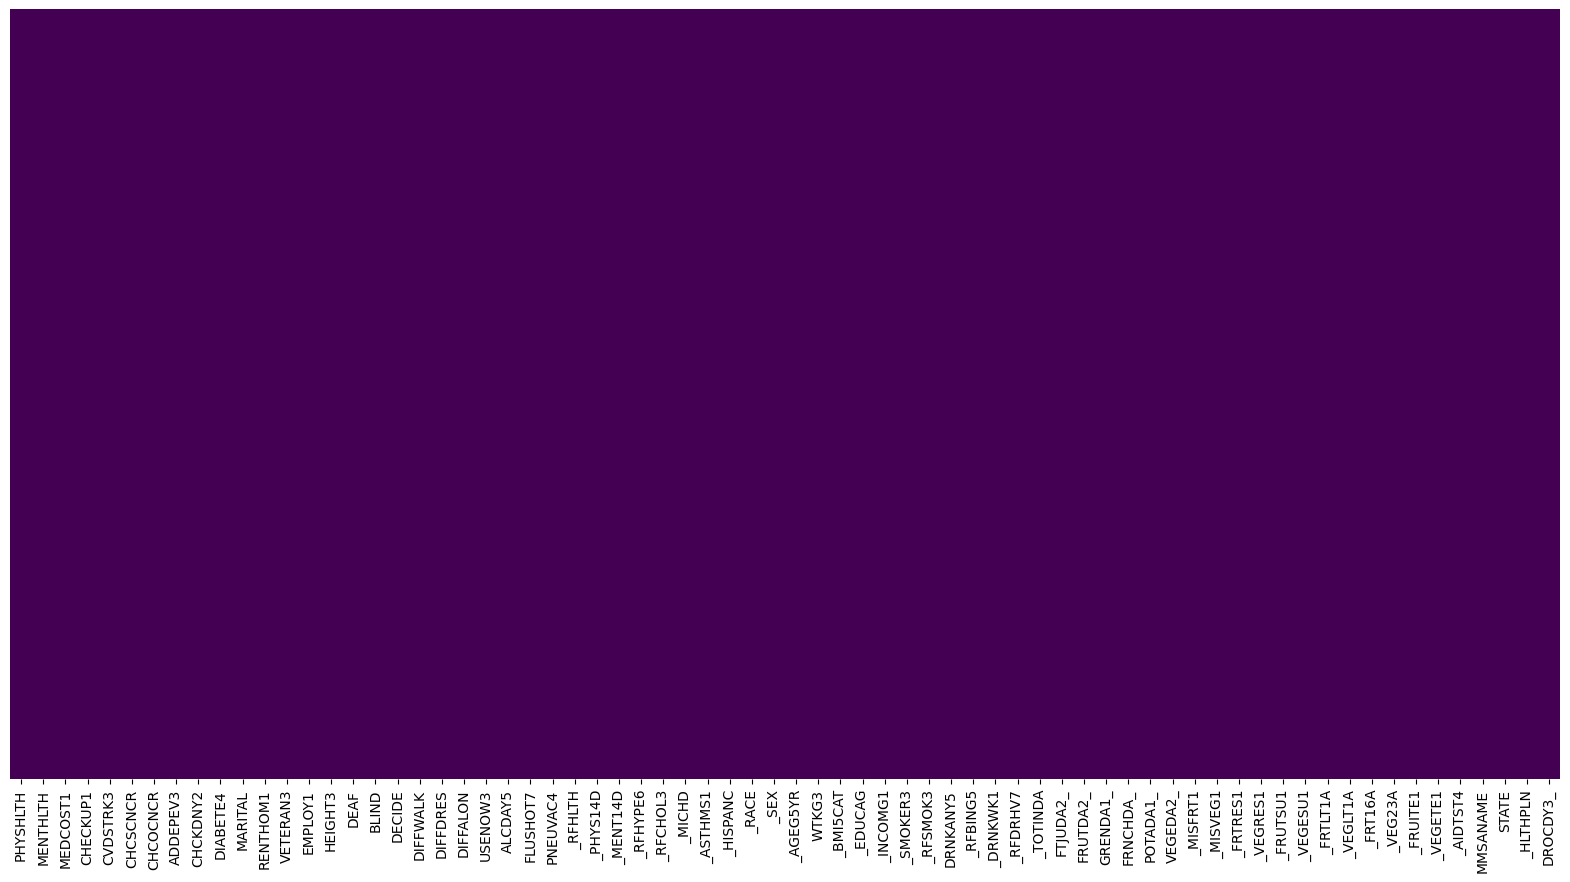

In [36]:
#vizualize misisng values using a heatmap
plt.figure(figsize=(20,10))
sns.heatmap(processed_features_df.isnull(),yticklabels=False,cmap='viridis',cbar=False)

In [37]:
#Lets Generate A profile report of the cleaned data
profile = ProfileReport(processed_features_df,minimal=True,dark_mode=True)
#profile.to_file(output_file="EDA_Report_Cleaned.html")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [38]:
processed_features_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 205651 entries, 1 to 227792
Data columns (total 70 columns):
 #   Column    Non-Null Count   Dtype   
---  ------    --------------   -----   
 0   PHYSHLTH  205651 non-null  category
 1   MENTHLTH  205651 non-null  category
 2   MEDCOST1  205651 non-null  category
 3   CHECKUP1  205651 non-null  category
 4   CVDSTRK3  205651 non-null  category
 5   CHCSCNCR  205651 non-null  category
 6   CHCOCNCR  205651 non-null  category
 7   ADDEPEV3  205651 non-null  category
 8   CHCKDNY2  205651 non-null  category
 9   DIABETE4  205651 non-null  category
 10  MARITAL   205651 non-null  category
 11  RENTHOM1  205651 non-null  category
 12  VETERAN3  205651 non-null  category
 13  EMPLOY1   205651 non-null  category
 14  HEIGHT3   205651 non-null  float64 
 15  DEAF      205651 non-null  category
 16  BLIND     205651 non-null  category
 17  DECIDE    205651 non-null  category
 18  DIFFWALK  205651 non-null  category
 19  DIFFDRES  205651 non-nu

In [39]:
processed_features_df.describe([0.25,0.50,0.75,0.99]).T

,count,mean,std,min,25%,50%,75%,99%,max
HEIGHT3,205651.0,1.703124,0.105205,0.9144,1.6256,1.701800,1.778,1.9304,2.413
WTKG3,205651.0,82.487918,20.546373,22.6800,68.0400,79.380000,92.080,145.1500,285.760
_DRNKWK1,205651.0,1151.557051,9281.954732,0.0000,0.0000,23.000000,280.000,8400.0000,99900.000
FTJUDA2_,205651.0,0.457135,3.870456,0.0000,0.0000,0.030000,0.290,3.0000,99.000
FRUTDA2_,205651.0,1.412170,5.371391,0.0000,0.4300,1.000000,1.000,7.0000,99.000
GRENDA1_,205651.0,0.860169,5.145618,0.0000,0.1400,0.430000,0.710,5.0000,99.000
FRNCHDA_,205651.0,0.245132,1.672763,0.0000,0.0300,0.140000,0.290,1.0000,99.000
POTADA1_,205651.0,0.269980,1.800270,0.0000,0.0700,0.140000,0.290,1.0000,99.000
VEGEDA2_,205651.0,1.470050,6.888856,0.0000,0.4300,1.000000,1.000,7.0000,99.000
_FRUTSU1,205651.0,1.855172,7.339736,0.0000,0.5700,1.000000,2.000,8.0000,198.000


In [40]:
# Replace outliers with the 99 percentile value except weight column

num_cols = ['HEIGHT3','_DRNKWK1','FTJUDA2_','FRUTDA2_','GRENDA1_','FRNCHDA_',
            'POTADA1_','VEGEDA2_','_FRUTSU1','_VEGESU1','DROCDY3_']

for i in num_cols:
    percentile_99 = np.percentile(processed_features_df[i], 99)
    processed_features_df.loc[processed_features_df[i] > percentile_99, i] = percentile_99


In [41]:
processed_features_df.describe([0.25,0.50,0.75,0.99]).T

,count,mean,std,min,25%,50%,75%,99%,max
HEIGHT3,205651.0,1.702693,0.104073,0.9144,1.6256,1.701800,1.778,1.9304,1.9304
WTKG3,205651.0,82.487918,20.546373,22.6800,68.0400,79.380000,92.080,145.1500,285.7600
_DRNKWK1,205651.0,348.595130,1004.148856,0.0000,0.0000,23.000000,280.000,8400.0000,8400.0000
FTJUDA2_,205651.0,0.276067,0.504671,0.0000,0.0000,0.030000,0.290,3.0000,3.0000
FRUTDA2_,205651.0,1.108015,1.069614,0.0000,0.4300,1.000000,1.000,7.0000,7.0000
GRENDA1_,205651.0,0.568290,0.681811,0.0000,0.1400,0.430000,0.710,5.0000,5.0000
FRNCHDA_,205651.0,0.192625,0.222615,0.0000,0.0300,0.140000,0.290,1.0000,1.0000
POTADA1_,205651.0,0.211171,0.227180,0.0000,0.0700,0.140000,0.290,1.0000,1.0000
VEGEDA2_,205651.0,0.973083,1.012998,0.0000,0.4300,1.000000,1.000,7.0000,7.0000
_FRUTSU1,205651.0,1.394661,1.281441,0.0000,0.5700,1.000000,2.000,8.0000,8.0000


- We can see the presence of significant multicolinearity between the fruits and vegetable columns, which we will
look to remove further down the line 

#### Export the processed df out to be split into training and validation data

In [42]:
processed_features_df.to_csv('mydata/MMSA2021_Cleaned.csv', index=False)

### EXPLORATORY DATA ANALYSIS

<Axes: >

<Figure size 1200x800 with 0 Axes>

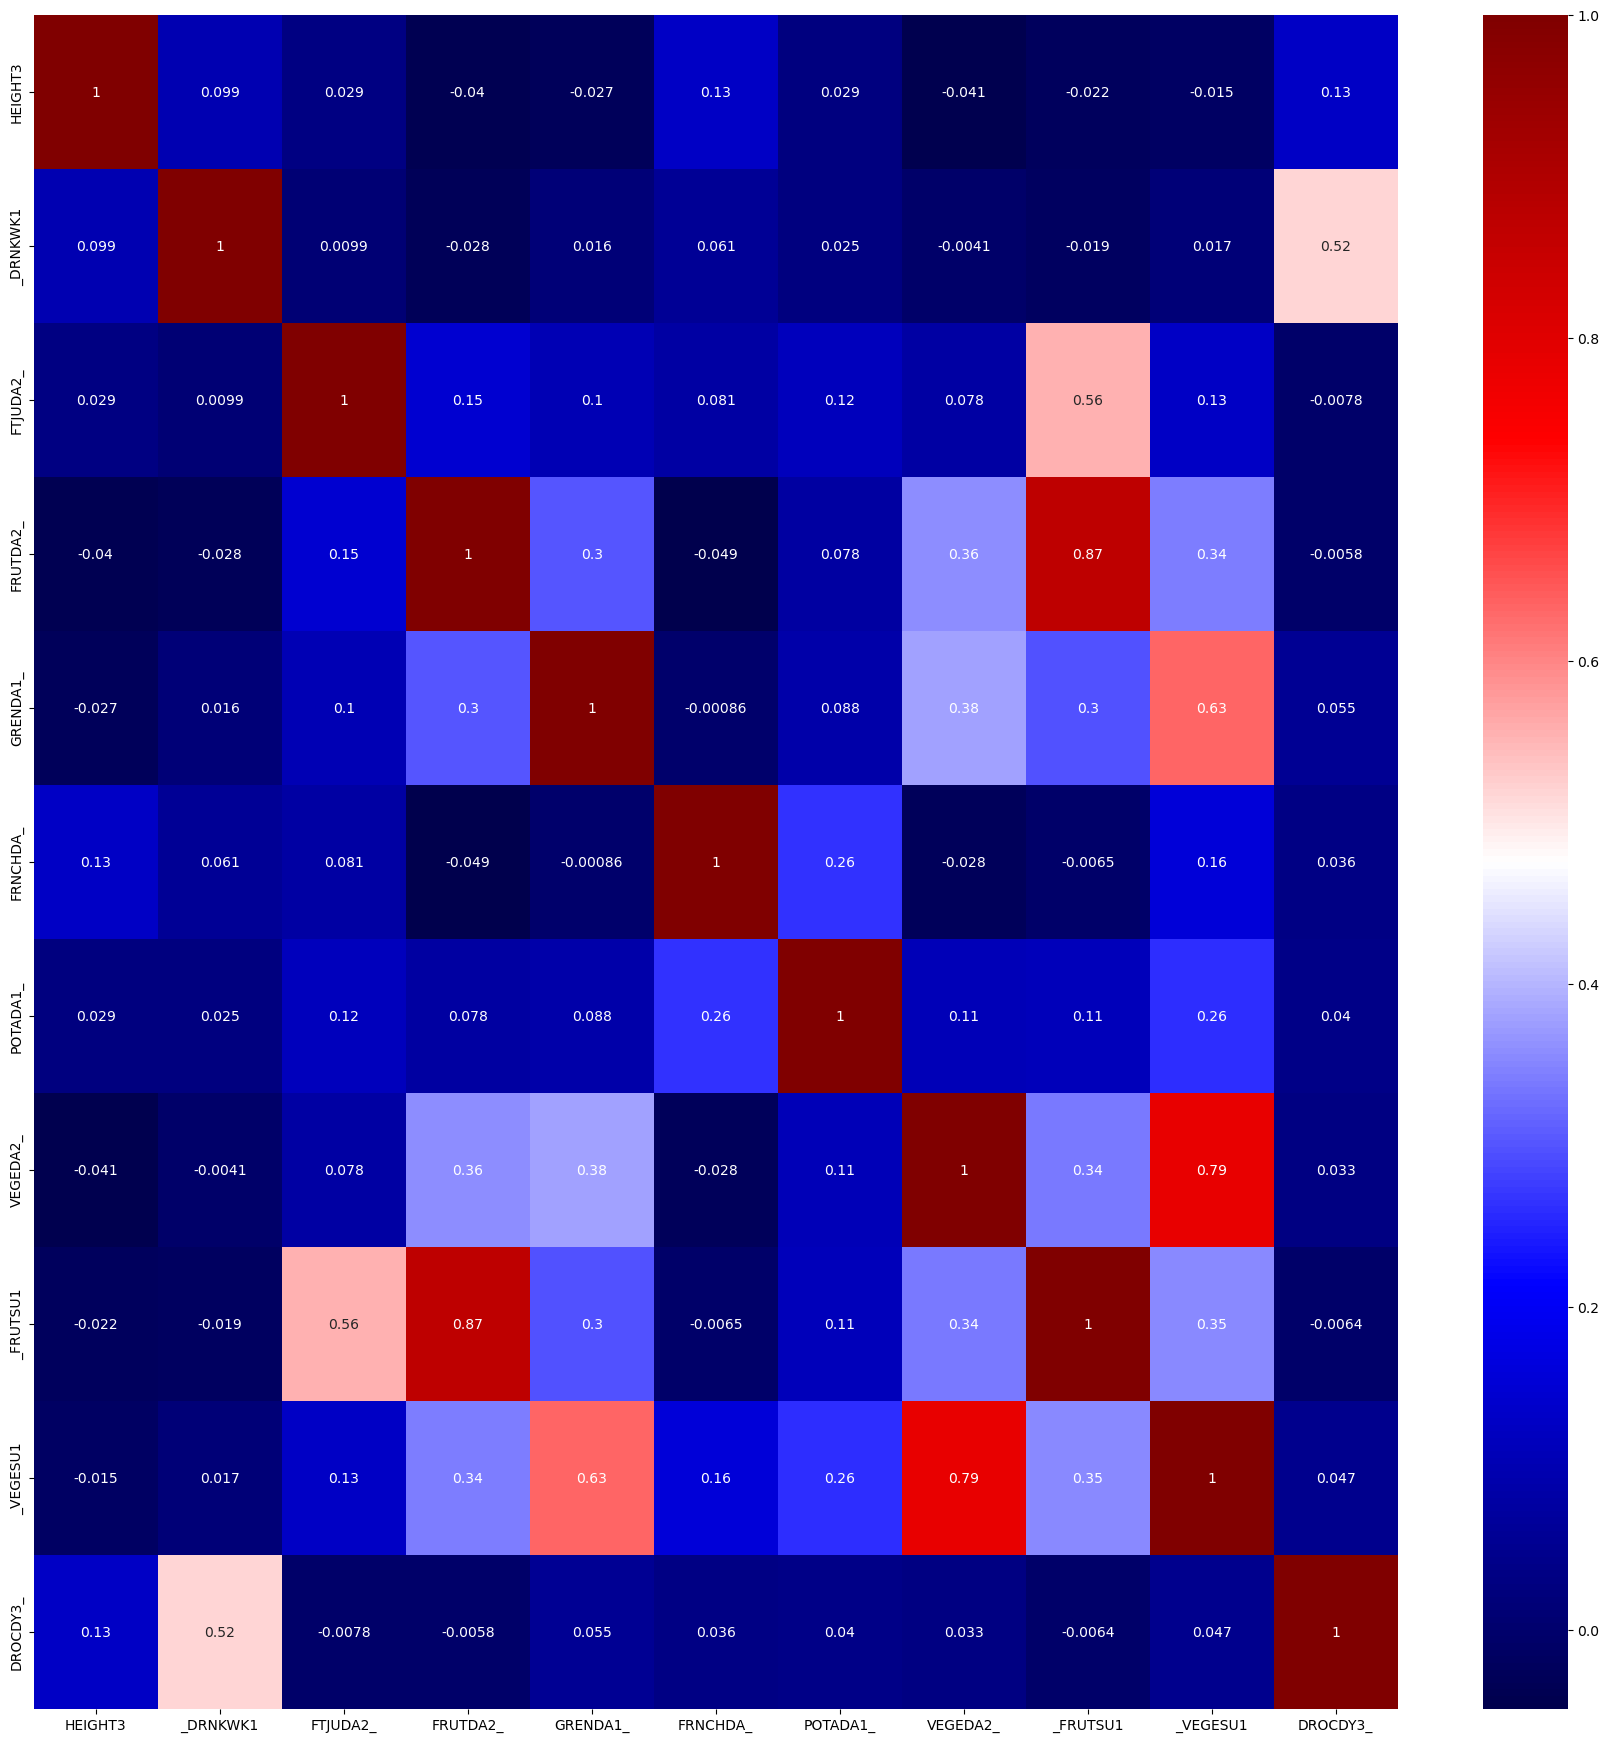

In [44]:
#Chesk for correlation between the numeric vairbales 
plt.figure(figsize=(12,8))
plt.figure(figsize=(22,22))
sns.heatmap(processed_features_df[num_cols].corr(),cmap='seismic',annot=True)

In [ ]:
###NOTE POORHLTH HAS ALMOST 50% MISSING DATA IN 2021 SO AFTER RUNNING FEATURE SELECTION ON 2019 DATA 